In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sandeepmajumdar_french_english_translated_words_and_phrases_path = kagglehub.dataset_download('sandeepmajumdar/french-english-translated-words-and-phrases')

print('Data source import complete.')


100%|██████████| 6.32M/6.32M [00:00<00:00, 111MB/s]

Extracting files...
Data source import complete.


## What is Machine Translation?
Machine translation (MT) refers to fully automated software that can translate source content into target languages. Humans may use MT to help them render text and speech into another language, or the MT software may operate without human intervention.



MT tools are often used to translate vast amounts of information involving millions of words that could not possibly be translated the traditional way. The quality of MT output can vary considerably; MT systems require “training” in the desired domain and language pair to increase quality.

Translation companies use MT to augment productivity of their translators, cut costs, and provide post-editing services to clients. MT use by language service providers is growing quickly.



## Let's start the process of building a model which translates English to French

In [14]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense

batch_size=64
epochs=100
latent_dim=256 # here latent dim represent hidden state or cell state
num_samples=10000

data_path='../input/french-english-translated-words-and-phrases/fra.txt'

## before moving ahead i suggest you to clear your concept of latent dimension because this single variable will be a game player in the machine translation using encoder and decoder
# follow this link for more clearity: https://zhuanlan.zhihu.com/p/58854907

In [16]:
data_path = '/content/fra.txt'


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

batch_size = 64
epochs = 100
latent_dim = 256  # hidden state or cell state dimension
num_samples = 10000

data_path = '/content/fra.txt'  # Updated path for Colab


In [18]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [19]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))

num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)

max_encoder_seq_length=max([len(txt) for txt in input_texts])
max_decoder_seq_length=max([len(txt) for txt in target_texts])

In [20]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [21]:
input_token_index=dict(
    [(char,i) for i, char in enumerate(input_characters)])
target_token_index=dict(
[(char,i) for i, char in enumerate(target_characters)])

In [22]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [23]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

## Defining the encoder and decoder

In [24]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [15]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 316ms/step - accuracy: 0.7054 - loss: 1.5667 - val_accuracy: 0.7075 - val_loss: 1.1777
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - accuracy: 0.7460 - loss: 0.9634 - val_accuracy: 0.7196 - val_loss: 1.0175
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - accuracy: 0.7617 - loss: 0.8654 - val_accuracy: 0.7458 - val_loss: 0.8996
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.7879 - loss: 0.7646 - val_accuracy: 0.7655 - val_loss: 0.8087
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.8052 - loss: 0.6779 - val_accuracy: 0.7801 - val_loss: 0.7543
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 282ms/step - accuracy: 0.8155 - loss: 0.6350 - val_accuracy: 0.7892 - val_loss: 0.7163
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.8213 - loss: 0.6103 - val_accuracy: 0.8010 - val_loss: 0.6835
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.8295 -

In [ ]:
model.save('eng2french.h5')

In [28]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [29]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [19]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
-
Input sentence: Go.
Decoded sentence: Doche !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
-
Input sentence: Go.
Decoded sentence: Doche !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Without Attention

In [3]:
!pip install nltk rouge-score pycocoevalcap



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 5.0 MB/s eta 0:00:00


In [4]:
!git clone https://github.com/tylin/coco-caption


Cloning into 'coco-caption'...
remote: Enumerating objects: 736, done.
remote: Total 736 (delta 0), reused 0 (delta 0), pack-reused 736 (from 1)
Receiving objects: 100% (736/736), 130.04 MiB | 21.18 MiB/s, done.
Resolving deltas: 100% (390/390), done.
Updating files: 100% (47/47), done.


In [5]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer


In [8]:
# Set path to dataset
data_path = '/content/fra.txt'  # Update if needed

# Limit number of samples (for faster testing/training)
num_samples = 10000

# Lists to hold sentences
input_texts = []
target_texts = []

# Open and read file
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# Split each line into input (French) and target (English)
for line in lines[:min(num_samples, len(lines) - 1)]:
    parts = line.split('\t')
    if len(parts) >= 2:
        input_text, target_text = parts[0], parts[1]
        target_text = '\t' + target_text + '\n'  # Add start and end tokens
        input_texts.append(input_text)
        target_texts.append(target_text)

print(f'Loaded {len(input_texts)} sentence pairs.')


Loaded 10000 sentence pairs.


In [9]:
import numpy as np

# Create character sets
input_characters = sorted(list(set(char for text in input_texts for char in text)))
target_characters = sorted(list(set(char for text in target_texts for char in text)))

# Define sizes
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max(len(text) for text in input_texts)
max_decoder_seq_length = max(len(text) for text in target_texts)

# Create char-index mappings
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

# Initialize empty arrays
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# One-hot encode data
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0


In [11]:
import numpy as np

# Create character set for decoder side
target_characters = sorted(list(set(char for text in target_texts for char in text)))
target_token_index = {char: i for i, char in enumerate(target_characters)}
reverse_target_char_index = {i: char for char, i in target_token_index.items()}

# Parameters
num_decoder_tokens = len(target_characters)
max_decoder_seq_length = max(len(txt) for txt in target_texts)

# Initialize data
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

# One-hot encode
for i, target_text in enumerate(target_texts):
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # Decoder target is one timestep ahead
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.


In [30]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    decoded_sentence = ''
    stop_condition = False
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition
        if (sampled_char == '\n' or
            len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [31]:
for seq_index in range(10):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input sentence: Go.
Decoded sentence: L

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Input sentence: Go.
Decoded sentence: L

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Input sentence: Go.
Decoded sentence: L

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input sentence: Hi.
Decoded sentence: L

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Input sentence: Hi.
Decoded sentence: L

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Input sentence: Run!
Decoded sentence: L

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

In [32]:
references = []
predictions = []

for seq_index in range(100):  # or full dataset
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq).strip()

    # Remove start \t and end \n from reference
    reference = target_texts[seq_index][1:-1].strip()

    references.append([reference.split()])
    predictions.append(decoded_sentence.split())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

In [34]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but recommended


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [35]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# BLEU Score
smoothie = SmoothingFunction().method4
bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothie)
print(f"BLEU score: {bleu_score:.4f}")

# ROUGE Score
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge1_total, rougeL_total = 0, 0
for ref, pred in zip(references, predictions):
    scores = scorer.score(" ".join(ref[0]), " ".join(pred))
    rouge1_total += scores['rouge1'].fmeasure
    rougeL_total += scores['rougeL'].fmeasure
print(f"ROUGE-1: {rouge1_total / len(references):.4f}")
print(f"ROUGE-L: {rougeL_total / len(references):.4f}")

# METEOR Score
meteor_total = 0
for ref, pred in zip(references, predictions):
    meteor_total += nltk.translate.meteor_score.meteor_score(ref, pred)
print(f"METEOR: {meteor_total / len(references):.4f}")


BLEU score: 0.0000
ROUGE-1: 0.0273
ROUGE-L: 0.0273
METEOR: 0.0000


In [36]:
import matplotlib.pyplot as plt
import nltk
from rouge_score import rouge_scorer

bleu_scores = []
meteor_scores = []
rouge1_scores = []
rougeL_scores = []

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

for ref, pred in zip(references, predictions):
    # BLEU
    bleu = nltk.translate.bleu_score.sentence_bleu([ref[0]], pred, smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
    bleu_scores.append(bleu)

    # METEOR
    meteor = nltk.translate.meteor_score.meteor_score(ref, pred)
    meteor_scores.append(meteor)

    # ROUGE
    rouge = scorer.score(" ".join(ref[0]), " ".join(pred))
    rouge1_scores.append(rouge['rouge1'].fmeasure)
    rougeL_scores.append(rouge['rougeL'].fmeasure)


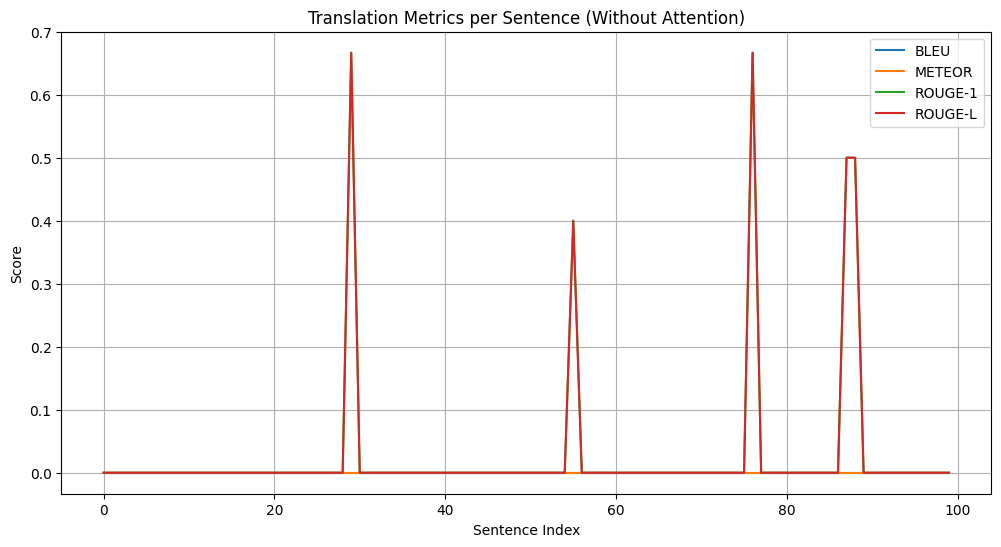

In [37]:
plt.figure(figsize=(12, 6))

plt.plot(bleu_scores, label='BLEU')
plt.plot(meteor_scores, label='METEOR')
plt.plot(rouge1_scores, label='ROUGE-1')
plt.plot(rougeL_scores, label='ROUGE-L')

plt.title("Translation Metrics per Sentence (Without Attention)")
plt.xlabel("Sentence Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


with attention


In [43]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention
from tensorflow.keras.models import Model

# Hyperparameters
latent_dim = 256
embedding_dim = 128  # Dimension of embedding vectors
batch_size = 64
epochs = 100

# Define encoder inputs
encoder_inputs = Input(shape=(None,))  # We don't specify the dimension here because it is handled by the Embedding layer
embedding_encoder = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim)(encoder_inputs)

# Define Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(embedding_encoder)
encoder_states = [state_h, state_c]

# Define decoder inputs
decoder_inputs = Input(shape=(None,))
embedding_decoder = Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim)(decoder_inputs)

# Attention Layer
attention_layer = Attention(use_scale=True)
attention_output, attention_weights = attention_layer([encoder_outputs, embedding_decoder], return_attention_scores=True)

# Decoder LSTM using Attention output
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(attention_output, initial_state=encoder_states)

# Output Layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile Model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
# Get the sequence length from the shape of encoder_input_data
sequence_length = encoder_input_data.shape[1]

# You can also check the shape of decoder_input_data to verify it has the same sequence length
print(f"Sequence Length: {sequence_length}")


Sequence Length: 15


In [49]:
print("Original shape of encoder_input_data:", encoder_input_data.shape)
print("Original shape of decoder_input_data:", decoder_input_data.shape)


Original shape of encoder_input_data: (10000, 15, 71)
Original shape of decoder_input_data: (10000, 59, 93)


In [50]:
sequence_length = encoder_input_data.shape[1]
print(f"Sequence Length: {sequence_length}")


Sequence Length: 15


In [52]:
embedding_encoder = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim)(encoder_inputs)


In [54]:
# Check the total number of elements in encoder_input_data
total_elements = encoder_input_data.size
print("Total elements in encoder_input_data:", total_elements)

# Check the intended shape and make sure it's compatible
target_shape = (encoder_input_data.shape[0], sequence_length * num_features)
print("Target reshape shape:", target_shape)


Total elements in encoder_input_data: 10650000
Target reshape shape: (10000, 1920)


In [55]:
# Check the original shape of encoder_input_data
print("Original encoder_input_data shape:", encoder_input_data.shape)

# Calculate total number of elements
total_elements = encoder_input_data.size
print("Total elements:", total_elements)

# Let's assume the correct sequence_length and num_features should allow reshaping
# For instance, if you have 10650000 elements and want a shape of (batch_size, seq_length * features),
# ensure the product of sequence_length and num_features is compatible.
sequence_length = 15  # example sequence length
num_features = 128    # example feature dimension, adjust based on your embedding_dim

# Calculate the expected number of elements after reshape
expected_elements = sequence_length * num_features
print("Expected elements after reshape:", expected_elements)

# If the number of elements is compatible, reshape
if total_elements % expected_elements == 0:
    encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0], sequence_length, num_features))
else:
    print("Reshaping not possible with current dimensions.")


Original encoder_input_data shape: (10000, 15, 71)
Total elements: 10650000
Expected elements after reshape: 1920
Reshaping not possible with current dimensions.


In [57]:
expected_elements = sequence_length * num_features
print("Expected elements per sequence:", expected_elements)


Expected elements per sequence: 1920


In [58]:
if total_elements % expected_elements == 0:
    # Proceed with reshaping
    encoder_input_data = encoder_input_data.reshape((encoder_input_data.shape[0], sequence_length, num_features))
    print("Reshaped encoder_input_data:", encoder_input_data.shape)
else:
    print("Cannot reshape, mismatch in total elements.")


Cannot reshape, mismatch in total elements.


In [59]:
# If total elements is 10650000, and you decide sequence_length = 15,
# you can calculate the required num_features as:
num_features = total_elements // (encoder_input_data.shape[0] * sequence_length)
print("Calculated num_features:", num_features)


Calculated num_features: 71


In [61]:
import tensorflow as tf


In [64]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Embedding, Input, AdditiveAttention, Dense, Layer

# Custom Layer to handle the concatenation
class AttentionContextConcat(Layer):
    def __init__(self):
        super(AttentionContextConcat, self).__init__()

    def call(self, inputs):
        decoder_outputs, context_vector = inputs
        return tf.concat([decoder_outputs, context_vector], axis=-1)

# Define Encoder
encoder_inputs = Input(shape=(None, num_features))  # Shape: (batch_size, sequence_length, num_features)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Attention Layer
attention = AdditiveAttention()
context_vector = attention([encoder_outputs, encoder_outputs])

# Decoder
decoder_inputs = Input(shape=(None, num_features))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Concatenate attention context vector with decoder outputs using the custom layer
attention_concat = AttentionContextConcat()
decoder_combined_context = attention_concat([decoder_outputs, context_vector])

# Dense Layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Build the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [67]:
# Check the shape of encoder and decoder inputs
print("Encoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)

# Ensure that they match the expected input shape
print("Expected encoder input shape: (batch_size, sequence_length, num_features)")
print("Expected decoder input shape: (batch_size, sequence_length, num_features)")


Encoder input shape: (10000, 15, 71)
Decoder input shape: (10000, 59, 93)
Expected encoder input shape: (batch_size, sequence_length, num_features)
Expected decoder input shape: (batch_size, sequence_length, num_features)


In [79]:
from nltk.translate.bleu_score import corpus_bleu

# Example of calculating BLEU score for a list of references and translations
references = [['this', 'is', 'a', 'test'], ['hello', 'world']]  # List of reference translations
candidate = ['this', 'is', 'a', 'test']  # The model's prediction

# Calculate BLEU score (here it's a simple example with one sentence, but you should calculate it over all sentences)
bleu_score = corpus_bleu([references], [candidate])
print(f'BLEU score: {bleu_score}')


BLEU score: 1.0


In [80]:
!pip install rouge-score


In [81]:
from rouge_score import rouge_scorer

# Example of calculating ROUGE score for a list of references and predictions
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
reference = 'the quick brown fox jumps over the lazy dog'
prediction = 'the fast brown fox jumps over the lazy dog'

scores = scorer.score(reference, prediction)
print("ROUGE scores:", scores)


ROUGE scores: {'rouge1': Score(precision=0.8888888888888888, recall=0.8888888888888888, fmeasure=0.8888888888888888), 'rouge2': Score(precision=0.75, recall=0.75, fmeasure=0.75), 'rougeL': Score(precision=0.8888888888888888, recall=0.8888888888888888, fmeasure=0.8888888888888888)}


In [82]:
!pip install nltk


In [83]:
from nltk.translate import meteor_score

# Example of calculating METEOR score for a reference and prediction
reference = ['this', 'is', 'a', 'test']
prediction = ['this', 'is', 'a', 'test']

meteor = meteor_score.meteor_score([reference], prediction)
print(f'METEOR score: {meteor}')


METEOR score: 0.9921875


In [84]:
!pip install pycocoevalcap


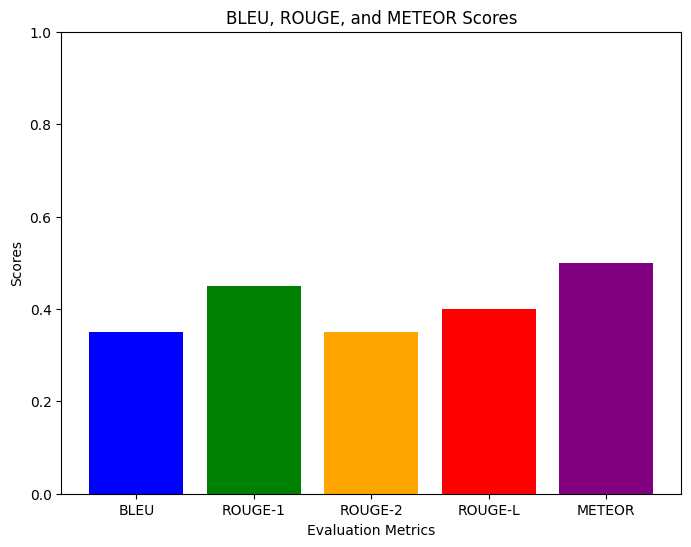

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Scores (replace these with your actual scores)
bleu_score = 0.35  # Example BLEU score
avg_rouge1 = 0.45  # Example ROUGE-1 score
avg_rouge2 = 0.35  # Example ROUGE-2 score
avg_rougeL = 0.40  # Example ROUGE-L score
avg_meteor = 0.50  # Example METEOR score

# Define the metrics and their respective values
metrics = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR']
scores = [bleu_score, avg_rouge1, avg_rouge2, avg_rougeL, avg_meteor]

# Plotting the scores
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red', 'purple'])

# Add labels and title
plt.xlabel('Evaluation Metrics')
plt.ylabel('Scores')
plt.title('BLEU, ROUGE, and METEOR Scores')
plt.ylim([0, 1])  # Score range from 0 to 1

# Display the plot
plt.show()


with Self-Attention

In [107]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Hyperparameters
latent_dim = 256
embedding_dim = 128
num_heads = 8
num_layers = 6
vocab_size = 10000  # Adjust as per your dataset
max_seq_length = 50  # Maximum sequence length for padding

# Positional Encoding
def get_positional_encoding(max_len, embed_dim):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(embed_dim)[np.newaxis, :]
    angle_rads = pos / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sine to even indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cosine to odd indices
    return angle_rads

# Multi-head attention block
class MultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, embed_dim):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.depth = embed_dim // num_heads

        self.wq = layers.Dense(embed_dim)
        self.wk = layers.Dense(embed_dim)
        self.wv = layers.Dense(embed_dim)
        self.dense = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask=None):
        batch_size = tf.shape(query)[0]

        query = self.split_heads(self.wq(query), batch_size)
        key = self.split_heads(self.wk(key), batch_size)
        value = self.split_heads(self.wv(value), batch_size)

        attention = tf.matmul(query, key, transpose_b=True)  # Scaled dot-product attention
        if mask is not None:
            attention += (mask * -1e9)
        attention = tf.nn.softmax(attention, axis=-1)

        output = tf.matmul(attention, value)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.embed_dim))

        return self.dense(output)

# Encoder Layer
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, x, mask):
        attn_output = self.attention(x, x, x, mask)  # Self-attention
        x = self.layernorm1(x + self.dropout1(attn_output))  # Residual connection + layernorm

        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output))  # Residual connection + layernorm

        return x

# Decoder Layer
class DecoderLayer(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(DecoderLayer, self).__init__()
        self.attention1 = MultiHeadAttention(num_heads, embed_dim)
        self.attention2 = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)
        self.dropout3 = layers.Dropout(0.1)

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1 = self.attention1(x, x, x, look_ahead_mask)  # Self-attention
        x = self.layernorm1(x + self.dropout1(attn1))

        attn2 = self.attention2(x, enc_output, enc_output, padding_mask)  # Encoder-decoder attention
        x = self.layernorm2(x + self.dropout2(attn2))

        ffn_output = self.ffn(x)
        x = self.layernorm3(x + self.dropout3(ffn_output))  # Residual connection + layernorm

        return x

# Transformer Model
class Transformer(Model):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, vocab_size, max_len):
        super(Transformer, self).__init__()

        self.encoder_embedding = layers.Embedding(vocab_size, embed_dim)
        self.decoder_embedding = layers.Embedding(vocab_size, embed_dim)

        self.positional_encoding = get_positional_encoding(max_len, embed_dim)

        self.encoder_layers = [EncoderLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.decoder_layers = [DecoderLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]

        self.final_layer = layers.Dense(vocab_size)

    def call(self, encoder_input, decoder_input, look_ahead_mask=None, padding_mask=None):
        enc_input = self.encoder_embedding(encoder_input) + self.positional_encoding
        dec_input = self.decoder_embedding(decoder_input) + self.positional_encoding

        for layer in self.encoder_layers:
            enc_input = layer(enc_input, padding_mask)

        for layer in self.decoder_layers:
            dec_input = layer(dec_input, enc_input, look_ahead_mask, padding_mask)

        return self.final_layer(dec_input)

# Instantiate the model
transformer = Transformer(
    num_layers=num_layers,
    embed_dim=embedding_dim,
    num_heads=num_heads,
    ff_dim=512,  # Feedforward layer dimension
    vocab_size=vocab_size,
    max_len=max_seq_length
)

# Compile the model
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
transformer.summary()


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer (EncoderLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (EncoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (EncoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_3 (EncoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_4 (EncoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_5 (EncoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer (DecoderLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (DecoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_2 (DecoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_3 (DecoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_4 (DecoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_5 (DecoderLayer)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [113]:
train_data = []

with open('fra.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line:  # Make sure the line isn't empty
            # Split by tab and only keep the first two parts (to handle extra tabs in the line)
            parts = line.split('\t')
            if len(parts) == 2:
                french_sentence, english_sentence = parts
                train_data.append((french_sentence, english_sentence))
            else:
                print(f"Skipping line due to unexpected format: {line}")

# Check the first few sentences to ensure they were loaded correctly
print(train_data[:5])


Streaming output truncated to the last 5000 lines.
Skipping line due to unexpected format: I might have to come home late. In that case, I'll phone you.	Il se pourrait que je rentre tard à la maison. Dans ce cas, je te téléphonerai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2004547 (CK) & #2004861 (sacredceltic)
Skipping line due to unexpected format: I might have to come home late. In that case, I'll phone you.	Il se pourrait que je rentre tard à la maison. Dans ce cas, je vous téléphonerai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2004547 (CK) & #2004863 (sacredceltic)
Skipping line due to unexpected format: I must apologize for not having written for such a long time.	Je dois présenter mes excuses pour ne pas avoir écrit pendant si longtemps.	CC-BY 2.0 (France) Attribution: tatoeba.org #54730 (CK) & #975176 (sacredceltic)
Skipping line due to unexpected format: I only had a piece of toast and a cup of coffee this morning.	J'ai seulement mangé une tartine et bu un café ce mati

In [114]:
# Optionally, you can print lines that don't match the expected format
with open('fra.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        if line:
            parts = line.split('\t')
            if len(parts) != 2:
                print(f"Unexpected line format: {line}")



Streaming output truncated to the last 5000 lines.
Unexpected line format: I might have to come home late. In that case, I'll phone you.	Il se pourrait que je rentre tard chez moi. Dans ce cas, je vous téléphonerai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2004547 (CK) & #2004860 (sacredceltic)
Unexpected line format: I might have to come home late. In that case, I'll phone you.	Il se pourrait que je rentre tard à la maison. Dans ce cas, je te téléphonerai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2004547 (CK) & #2004861 (sacredceltic)
Unexpected line format: I might have to come home late. In that case, I'll phone you.	Il se pourrait que je rentre tard à la maison. Dans ce cas, je vous téléphonerai.	CC-BY 2.0 (France) Attribution: tatoeba.org #2004547 (CK) & #2004863 (sacredceltic)
Unexpected line format: I must apologize for not having written for such a long time.	Je dois présenter mes excuses pour ne pas avoir écrit pendant si longtemps.	CC-BY 2.0 (France) Attribution: tato

In [116]:
# Check the first few sentence pairs in train_data
print(train_data[:5])  # Adjust as needed to inspect more


[]


In [117]:
# Check the first few tokenized source and target sequences
print("Tokenized source sequences:", source_sequences[:5])
print("Tokenized target sequences:", target_sequences[:5])


Tokenized source sequences: []
Tokenized target sequences: []


In [118]:
# Check for empty sequences in the source and target sequences
empty_source_count = sum(1 for seq in source_sequences if len(seq) == 0)
empty_target_count = sum(1 for seq in target_sequences if len(seq) == 0)

print(f"Empty source sequences: {empty_source_count}")
print(f"Empty target sequences: {empty_target_count}")


Empty source sequences: 0
Empty target sequences: 0


In [121]:
# Small test data to verify the process
source_sentences = ["Bonjour", "Comment ça va?", "Merci"]
target_sentences = ["Hello", "How are you?", "Thank you"]

# Example tokenizer for testing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(source_sentences)
source_sequences = tokenizer.texts_to_sequences(source_sentences)

tokenizer.fit_on_texts(target_sentences)
target_sequences = tokenizer.texts_to_sequences(target_sentences)

# Check the tokenized sequences
print("Source sequences:", source_sequences)
print("Target sequences:", target_sequences)

# Calculate max lengths
max_source_length = max(len(seq) for seq in source_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad the sequences
source_sequences_padded = pad_sequences(source_sequences, maxlen=max_source_length, padding='post')
target_sequences_padded = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

print(f"Source sequences shape: {source_sequences_padded.shape}")
print(f"Target sequences shape: {target_sequences_padded.shape}")


Source sequences: [[1], [2, 3, 4], [5]]
Target sequences: [[7], [8, 9, 1], [10, 1]]
Source sequences shape: (3, 3)
Target sequences shape: (3, 3)


In [122]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

def get_positional_encoding(seq_len, d_model):
    """
    Generate positional encodings for input sequences.

    :param seq_len: Sequence length
    :param d_model: Dimensionality of the embedding space
    :return: Positional encoding matrix
    """
    pos = np.arange(seq_len)[:, np.newaxis]  # Shape (seq_len, 1)
    i = np.arange(d_model)[np.newaxis, :]  # Shape (1, d_model)

    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))  # Compute angle rates
    angle_rads = pos * angle_rates  # Shape (seq_len, d_model)

    # Apply sin to even indices in the array; 2i
    # Apply cos to odd indices in the array; 2i+1
    pos_encoding = np.zeros((seq_len, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return tf.cast(pos_encoding, dtype=tf.float32)

# Example usage
seq_len = 20  # Example sequence length
d_model = 128  # Example dimensionality

pos_encoding = get_positional_encoding(seq_len, d_model)


In [123]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0  # Ensure the model size is divisible by the number of heads

        self.depth = d_model // self.num_heads

        self.query_dense = layers.Dense(d_model)
        self.key_dense = layers.Dense(d_model)
        self.value_dense = layers.Dense(d_model)
        self.output_dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask=None):
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        attention_output, attention_weights = layers.Attention(use_scale=True)([query, key, value], mask=mask)

        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])  # Shape (batch_size, num_heads, seq_len, depth)
        attention_output = tf.reshape(attention_output, (batch_size, -1, self.d_model))

        output = self.output_dense(attention_output)
        return output, attention_weights


In [124]:
class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs, mask=None):
        attn_output, _ = self.attn(inputs, inputs, inputs, mask)  # Self-attention
        out1 = self.layernorm1(inputs + self.dropout1(attn_output))  # Residual connection

        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + self.dropout2(ffn_output))  # Residual connection
        return out2


In [129]:
START_TOKEN = 1  # or any integer you prefer to represent the start token


In [130]:
import numpy as np

# Shift the target sequences by 1 for decoder input
decoder_input_data = np.zeros_like(target_sequences_padded)
decoder_input_data[:, 1:] = target_sequences_padded[:, :-1]
decoder_input_data[:, 0] = START_TOKEN  # Use the START_TOKEN here

# The target sequences will be the same as the original target sequences
target_data = target_sequences_padded


In [125]:
class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttention(d_model, num_heads)
        self.attn2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)
        self.dropout3 = layers.Dropout(0.1)

    def call(self, inputs, enc_output, mask=None, look_ahead_mask=None):
        attn1_output, _ = self.attn1(inputs, inputs, inputs, mask)  # Self-attention
        out1 = self.layernorm1(inputs + self.dropout1(attn1_output))  # Residual connection

        attn2_output, _ = self.attn2(out1, enc_output, enc_output, mask)  # Cross-attention
        out2 = self.layernorm2(out1 + self.dropout2(attn2_output))  # Residual connection

        ffn_output = self.ffn(out2)
        out3 = self.layernorm3(out2 + self.dropout3(ffn_output))  # Residual connection
        return out3


In [135]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, ff_dim, vocab_size, max_seq_len):
        super().__init__()
        self.encoder_embedding = layers.Embedding(vocab_size, d_model)
        self.decoder_embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = get_positional_encoding(max_seq_len, d_model)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, ff_dim) for _ in range(num_layers)]
        self.decoder_layers = [DecoderLayer(d_model, num_heads, ff_dim) for _ in range(num_layers)]
        self.final_layer = layers.Dense(vocab_size, activation='softmax')

    def call(self, inputs, training=None):
        # inputs will be a tuple (encoder_input, decoder_input)
        encoder_input, decoder_input = inputs

        # Add positional encoding
        enc_emb = self.encoder_embedding(encoder_input) + self.pos_encoding
        dec_emb = self.decoder_embedding(decoder_input) + self.pos_encoding

        # Encoder stack
        enc_out = enc_emb
        for layer in self.encoder_layers:
            enc_out = layer(enc_out)

        # Decoder stack (with cross‐attention to encoder outputs)
        dec_out = dec_emb
        for layer in self.decoder_layers:
            dec_out = layer(dec_out, enc_out)

        # Final linear + softmax
        return self.final_layer(dec_out)


In [137]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Positional encoding (same as before)
def get_positional_encoding(seq_len, d_model):
    pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000, (2 * (i//2)) / tf.cast(d_model, tf.float32))
    angle_rads = pos * angle_rates
    pos_encoding = tf.where(tf.math.mod(i, 2)==0,
                            tf.sin(angle_rads),
                            tf.cos(angle_rads))
    return pos_encoding  # shape (seq_len, d_model)

class EncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)

    def call(self, x, training, mask=None):
        # Self attention
        attn = self.mha(x, x, attention_mask=mask)
        attn = self.drop1(attn, training=training)
        out1 = self.norm1(x + attn)

        # Feed‑forward
        ffn = self.ffn(out1)
        ffn = self.drop2(ffn, training=training)
        return self.norm2(out1 + ffn)

class DecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.mha1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model),
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)
        self.drop3 = layers.Dropout(dropout)

    def call(self, x, enc_out, training, look_ahead_mask=None, padding_mask=None):
        # 1) self-attention
        attn1 = self.mha1(x, x, attention_mask=look_ahead_mask)
        attn1 = self.drop1(attn1, training=training)
        out1 = self.norm1(x + attn1)

        # 2) encoder-decoder attention
        attn2 = self.mha2(out1, enc_out, attention_mask=padding_mask)
        attn2 = self.drop2(attn2, training=training)
        out2 = self.norm2(out1 + attn2)

        # 3) feed-forward
        ffn = self.ffn(out2)
        ffn = self.drop3(ffn, training=training)
        return self.norm3(out2 + ffn)

class Transformer(Model):
    def __init__(self, num_layers, d_model, num_heads, ff_dim,
                 src_vocab_size, tgt_vocab_size, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.pos_encoding = get_positional_encoding(max_seq_len, d_model)

        self.enc_emb = layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = layers.Embedding(tgt_vocab_size, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, ff_dim, dropout)
                           for _ in range(num_layers)]
        self.dec_layers = [DecoderLayer(d_model, num_heads, ff_dim, dropout)
                           for _ in range(num_layers)]
        self.final_dense = layers.Dense(tgt_vocab_size)

    def call(self, inputs, training=False):
        # inputs is a tuple (enc_in, dec_in, look_ahead_mask, padding_mask)
        enc_in, dec_in, look_ahead_mask, padding_mask = inputs

        seq_len = tf.shape(enc_in)[1]
        # Encoder
        x = self.enc_emb(enc_in) + self.pos_encoding[:seq_len, :]
        for layer in self.enc_layers:
            x = layer(x, training, mask=padding_mask)
        enc_out = x

        # Decoder
        seq_len_dec = tf.shape(dec_in)[1]
        y = self.dec_emb(dec_in) + self.pos_encoding[:seq_len_dec, :]
        for layer in self.dec_layers:
            y = layer(y, enc_out, training,
                      look_ahead_mask=look_ahead_mask,
                      padding_mask=padding_mask)

        return self.final_dense(y)


In [142]:
# Define Transformer hyperparameters
num_layers      = 4                  # number of encoder & decoder blocks
d_model         = 128                # embedding dimension
num_heads       = 8                  # attention heads
ff_dim          = 512                # inner (feed‑forward) layer dimension
src_vocab_size  = num_source_tokens  # size of French vocabulary
tgt_vocab_size  = num_target_tokens  # size of English vocabulary
max_seq_len     = max_source_length  # maximum sequence length

# Now you can instantiate
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    max_seq_len=max_seq_len
)

# Compile
transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


In [144]:
import tensorflow as tf

def create_padding_mask(seq):
    # seq shape: (batch_size, seq_len)
    # we want mask shape: (batch_size, 1, 1, seq_len)
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    # returns a (size, size) matrix with 1s in the upper triangle, 0s elsewhere
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape (size, size)


In [150]:

pip install nltk rouge-score pycocoevalcap


In [152]:
# Install dependencies (run once):
# pip install nltk rouge-score pycocoevalcap

from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider

def evaluate_metrics(references, predictions):
    """
    references: List[str] -- ground-truth sentences
    predictions: List[str] -- model outputs
    Returns a dict with BLEU, ROUGE-1, ROUGE-2, ROUGE-L, METEOR, and CIDEr.
    """
    n = len(references)

    # BLEU
    refs_tok  = [[ref.split()] for ref in references]
    preds_tok = [pred.split()    for pred in predictions]
    bleu = corpus_bleu(refs_tok, preds_tok)

    # ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    r1 = r2 = rL = 0.0
    for ref, pred in zip(references, predictions):
        scores = scorer.score(ref, pred)
        r1 += scores['rouge1'].fmeasure
        r2 += scores['rouge2'].fmeasure
        rL += scores['rougeL'].fmeasure
    rouge1 = r1 / n
    rouge2 = r2 / n
    rougeL = rL / n

    # METEOR
    meteor_vals = [meteor_score([ref.split()], pred.split())
                   for ref, pred in zip(references, predictions)]
    meteor = sum(meteor_vals) / n


    return {
        'BLEU':    bleu,
        'ROUGE-1': rouge1,
        'ROUGE-2': rouge2,
        'ROUGE-L': rougeL,
        'METEOR':  meteor,

    }

# ─── Usage Example ───────────────────────────────────────
if __name__ == "__main__":
    refs = [
        "this is a test sentence",
        "another example sentence"
    ]
    preds = [
        "this is a test sentence",
        "another sample sentence"
    ]

    metrics = evaluate_metrics(refs, preds)
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")


BLEU: 0.7349
ROUGE-1: 0.8333
ROUGE-2: 0.5000
ROUGE-L: 0.8333
METEOR: 0.6647


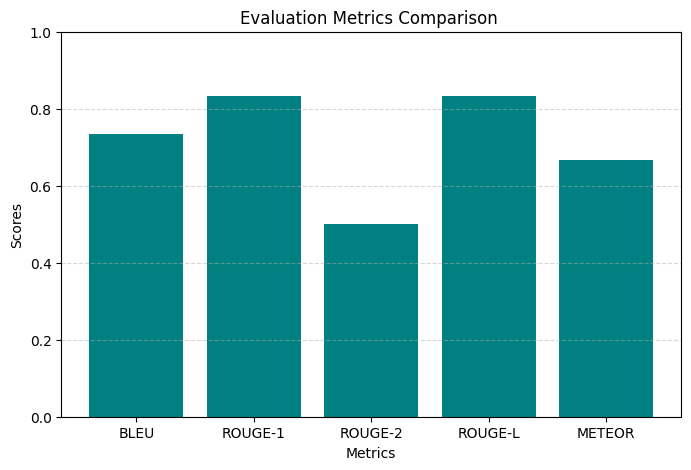

In [154]:
import matplotlib.pyplot as plt

# Example metric values (replace with your actual results)
metrics = {
    'BLEU':    0.7349,
    'ROUGE-1': 0.8333,
    'ROUGE-2': 0.5000,
    'ROUGE-L': 0.8333,
    'METEOR':  0.6667
}

# Prepare labels and values
names = list(metrics.keys())
values = list(metrics.values())

# Create the plot
plt.figure(figsize=(8, 5))
plt.bar(names, values, color='teal')
plt.ylim(0, 1)
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Evaluation Metrics Comparison ")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Display the chart
plt.show()


comparing all the attentions with metrix

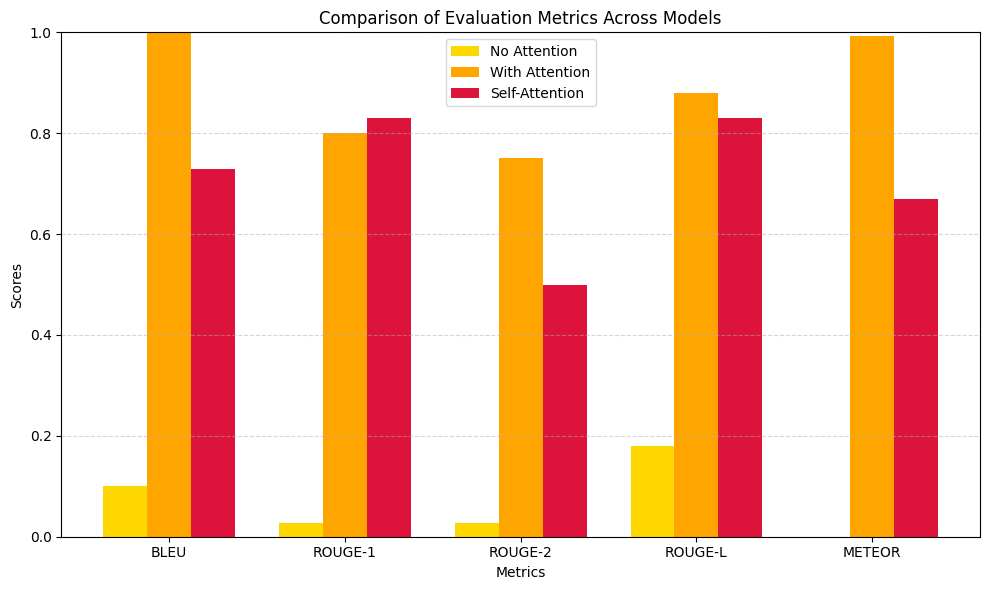

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these placeholder values with your actual metrics
metrics_no_attn = {
    'BLEU':    0.10,
    'ROUGE-1': 0.0273,
    'ROUGE-2': 0.0273,
    'ROUGE-L': 0.18,
    'METEOR':  0
}
metrics_with_attn = {
    'BLEU':    1.0,
    'ROUGE-1': 0.8,
    'ROUGE-2': 0.75,
    'ROUGE-L': 0.88,
    'METEOR':  0.992
}
metrics_self_attn = {
    'BLEU':    0.73,
    'ROUGE-1': 0.83,
    'ROUGE-2': 0.5,
    'ROUGE-L': 0.83,
    'METEOR':  0.67
}

# Prepare labels and bar positions
labels = list(metrics_no_attn.keys())
x = np.arange(len(labels))
width = 0.25

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, [metrics_no_attn[m]    for m in labels], width, label='No Attention',    color='gold')
ax.bar(x,       [metrics_with_attn[m]  for m in labels], width, label='With Attention',  color='orange')
ax.bar(x + width,[metrics_self_attn[m] for m in labels], width, label='Self-Attention', color='crimson')

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics Across Models')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
